In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from pathlib import Path

from PIL import Image
import albumentations as A

pd.set_option('display.max_columns', 100)

In [14]:
# Default portion in grams
default_portions = {
    # Breakfast items
    'apple_pie': 125,
    'baby_back_ribs': 250,
    'baklava': 75,
    'beef_carpaccio': 85,
    'beef_tartare': 100,
    'beet_salad': 150,
    'beignets': 60,
    'bibimbap': 400,
    'bread_pudding': 140,
    'breakfast_burrito': 250,
    
    'bruschetta': 50,
    'caesar_salad': 200,
    'cannoli': 85,
    'caprese_salad': 150,
    'carrot_cake': 120,
    'ceviche': 120,
    'cheesecake': 125,             
    'cheese_plate': 100,
    'chicken_curry': 300,
    'chicken_quesadilla': 180,
    'chicken_wings': 140,
    'chocolate_cake': 110,
    'chocolate_mousse': 100,
    'churros': 80,
    'clam_chowder': 250,
    'club_sandwich': 300, 
    'crab_cakes': 120,
    'creme_brulee': 140,
    'croque_madame': 250,
    'cup_cakes': 50,
    
    'deviled_eggs': 60,
    'donuts': 65,
    'dumplings': 120,
    'edamame': 155,
    'eggs_benedict': 280,
    'escargots': 75,
    'falafel': 100,
    'filet_mignon': 180,
    'fish_and_chips': 400,
    'foie_gras': 60, 
    'french_fries': 150,
    'french_onion_soup': 250, 
    'french_toast': 150,
    'fried_calamari': 150,
    'fried_rice': 250,
    
    'frozen_yogurt': 150,
    'garlic_bread': 80,
    'gnocchi': 200,
    'greek_salad': 180,
    'grilled_cheese_sandwich': 120,
    'grilled_salmon': 150,
    'guacamole': 100,
    'gyoza': 100,
    'hamburger': 220,
    'hot_and_sour_soup': 240,
    'hot_dog': 100,
    'huevos_rancheros': 250,
    'hummus': 100,
    'ice_cream': 100,
    'lasagna': 250,
    'lobster_bisque': 240,
    'lobster_roll_sandwich': 200,
    'macaroni_and_cheese': 200,
    'macarons': 40,
    'miso_soup': 240,
    'mussels': 150,
    'nachos': 180,
    'omelette': 120,
    'onion_rings': 120,
    'oysters': 100,
    'pad_thai': 300,
    'paella': 350,
    'pancakes': 150,
    'panna_cotta': 120,
    'peking_duck': 200, 
    'pho': 450,
    'pizza': 140,
    'pork_chop': 180,
    'poutine': 350,
    'prime_rib': 220, 
    'pulled_pork_sandwich': 250, 
    'ramen': 400, 
    'ravioli': 200, 
    'red_velvet_cake': 120, 
    'risotto': 200, 
    'samosa': 100,
    'sashimi': 100, 
    'scallops': 100, 
    'seaweed_salad': 100,
    'shrimp_and_grits': 300,
    'spaghetti_bolognese': 300, 
    'spaghetti_carbonara': 300,
    'spring_rolls': 80,
    'steak': 200,  
    'strawberry_shortcake': 120, 
    'sushi': 150,
    'tacos': 150,
    'takoyaki': 100,
    'tiramisu': 120,
    'tuna_tartare': 100,
    'waffles': 150,
}

portions_df=pd.DataFrame(list(default_portions.items()), columns=['food_class', 'default_portion_g'])
portions_df.to_csv('../../data/food-101/food-101-portions/default_portions.csv', index=False)

print(f'Mean portion size: {portions_df['default_portion_g'].mean():.2f}g')
print(f'Median portion size: {portions_df['default_portion_g'].median():.2f}g')
print(f'Minimum size: {portions_df['default_portion_g'].min()}g ({portions_df.loc[portions_df['default_portion_g'].idxmin(), 'food_class']})')
print(f'Maximum size: {portions_df['default_portion_g'].max()}g ({portions_df.loc[portions_df['default_portion_g'].idxmax(), 'food_class']})')

Mean portion size: 169.11g
Median portion size: 150.00g
Minimum size: 40g (macarons)
Maximum size: 450g (pho)


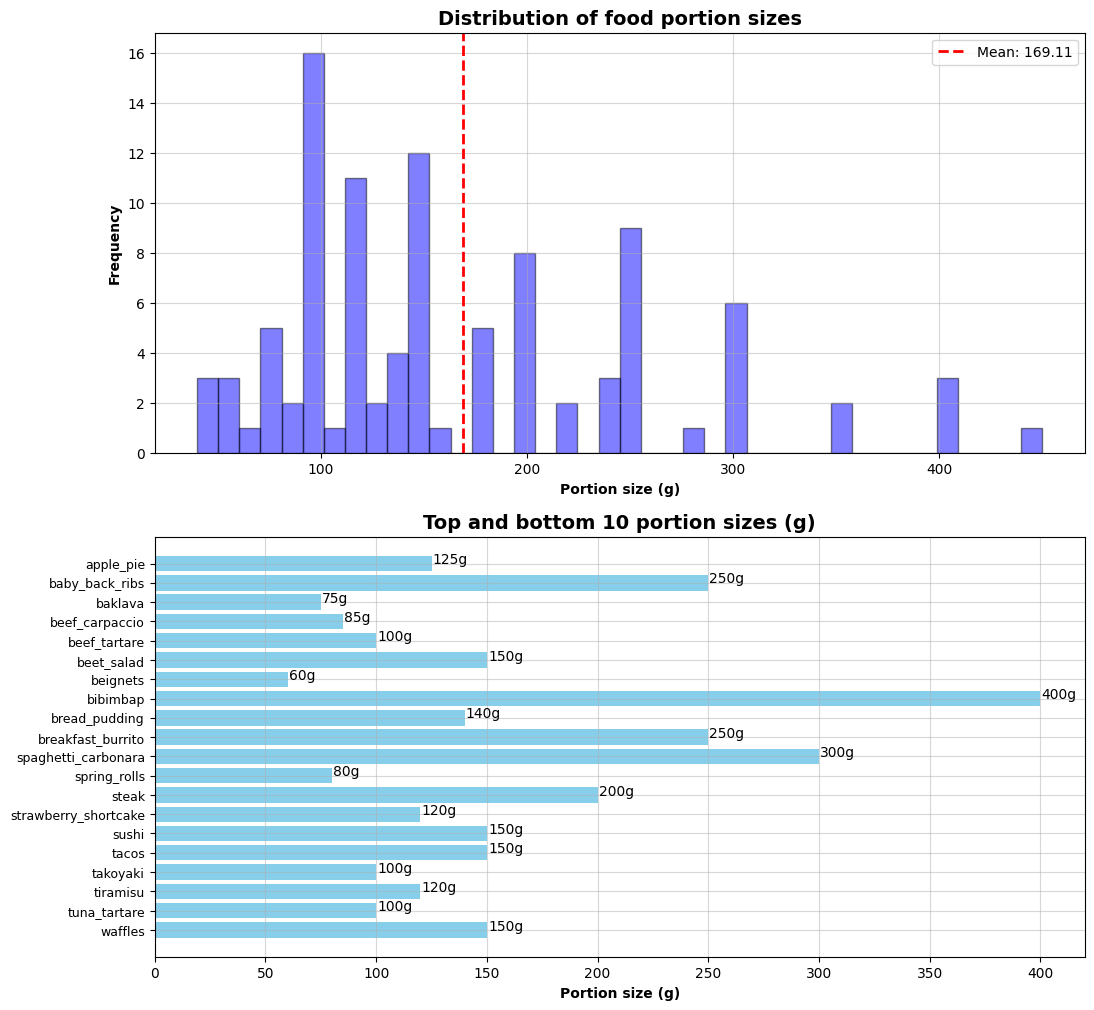

In [15]:
# Portion distribution
fig, ax=plt.subplots(2, 1, figsize=(12, 12))

ax[0].hist(portions_df['default_portion_g'], bins=40, edgecolor='black', color='blue', alpha=0.5)
ax[0].axvline(portions_df['default_portion_g'].mean(), color='red', linestyle='--', linewidth=2, label=(f'Mean: {portions_df['default_portion_g'].mean():.2f}'))
ax[0].set_xlabel('Portion size (g)', fontsize=10, fontweight='bold')
ax[0].set_ylabel('Frequency', fontsize=10, fontweight='bold')
ax[0].set_title('Distribution of food portion sizes', fontsize=14, fontweight='bold')
ax[0].legend()
ax[0].grid(alpha=0.5)

portions_sorted=portions_df.sort_values('default_portion_g', ascending=False)
top_bottom=pd.concat([portions_df.head(10), portions_df.tail(10)])

bars=ax[1].barh(range(len(top_bottom)), top_bottom['default_portion_g'], color='skyblue')
ax[1].set_xlabel('Portion size (g)', fontsize=10, fontweight='bold')
ax[1].set_yticks(range(len(top_bottom)))
ax[1].set_yticklabels(top_bottom['food_class'], fontsize=9)
ax[1].set_title('Top and bottom 10 portion sizes (g)', fontsize=14, fontweight='bold')
ax[1].invert_yaxis()
ax[1].grid(alpha=0.5)

for i, bar in enumerate(bars): 
    width=bar.get_width()
    ax[1].text(width + 0.5, bar.get_y() + bar.get_height() / 2, f'{width}g')

plt.savefig('figures/food_portion_distribution', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
# Nutritional data: calories, protein, carbs, fat, fiber
nutritional_data = {
    'apple_pie': [237, 2.0, 34.0, 11.0, 1.6],
    'baby_back_ribs': [290, 26.0, 0.0, 21.0, 0.0],
    'baklava': [428, 5.5, 52.0, 23.0, 2.3],
    'beef_carpaccio': [127, 22.0, 0.5, 4.5, 0.0],
    'beef_tartare': [150, 20.0, 3.0, 7.0, 0.0],
    'beet_salad': [45, 1.7, 10.0, 0.2, 2.8],
    'beignets': [350, 6.0, 42.0, 17.0, 1.2],
    'bibimbap': [160, 8.0, 25.0, 3.5, 2.0],
    'bread_pudding': [215, 5.5, 31.0, 7.5, 0.8],
    'breakfast_burrito': [215, 11.0, 22.0, 9.0, 2.5],
    
    'bruschetta': [150, 4.5, 22.0, 4.5, 1.8],
    'caesar_salad': [190, 8.0, 8.0, 14.0, 2.0],
    'cannoli': [300, 6.0, 35.0, 15.0, 1.0],
    'caprese_salad': [180, 10.0, 4.0, 14.0, 1.0],
    'carrot_cake': [350, 4.0, 50.0, 16.0, 2.0],
    'ceviche': [87, 13.0, 5.0, 1.5, 0.5],
    'cheesecake': [321, 5.5, 25.0, 23.0, 0.5],
    'cheese_plate': [400, 25.0, 3.0, 33.0, 0.0],
    'chicken_curry': [165, 12.0, 8.0, 10.0, 2.0],
    'chicken_quesadilla': [230, 15.0, 20.0, 11.0, 1.5],
    'chicken_wings': [290, 27.0, 0.0, 19.0, 0.0],
    'chocolate_cake': [370, 5.0, 50.0, 18.0, 3.0],
    'chocolate_mousse': [190, 3.5, 20.0, 11.0, 1.5],
    'churros': [330, 5.0, 46.0, 14.0, 1.5],
    'clam_chowder': [85, 5.5, 10.0, 2.5, 1.0],
    'club_sandwich': [240, 18.0, 22.0, 10.0, 2.0],
    'crab_cakes': [188, 12.0, 8.5, 11.0, 0.5],
    'creme_brulee': [288, 4.5, 26.0, 18.0, 0.0],
    'croque_madame': [290, 17.0, 20.0, 16.0, 1.0],
    'cup_cakes': [350, 4.0, 50.0, 15.0, 1.0],
    
    'deviled_eggs': [145, 13.0, 1.0, 10.0, 0.0],
    'donuts': [452, 5.0, 51.0, 25.0, 1.5],
    'dumplings': [180, 7.0, 28.0, 4.5, 1.5],
    'edamame': [122, 11.0, 10.0, 5.0, 5.0],
    'eggs_benedict': [230, 13.0, 15.0, 13.0, 0.5],
    'escargots': [90, 16.0, 2.0, 1.5, 0.0],
    'falafel': [333, 13.0, 32.0, 18.0, 4.5],
    'filet_mignon': [227, 26.0, 0.0, 13.0, 0.0],
    'fish_and_chips': [230, 12.0, 22.0, 11.0, 1.5],
    'foie_gras': [462, 11.0, 1.3, 44.0, 0.0],
    'french_fries': [312, 3.4, 41.0, 15.0, 3.8],
    'french_onion_soup': [57, 3.8, 8.0, 1.7, 1.0],
    'french_toast': [240, 8.0, 32.0, 9.0, 1.5],
    'fried_calamari': [175, 15.0, 8.0, 9.0, 0.5],
    'fried_rice': [163, 4.8, 28.0, 3.0, 0.8],
    
    'frozen_yogurt': [127, 4.0, 24.0, 1.5, 0.5],
    'garlic_bread': [350, 9.0, 44.0, 15.0, 2.0],
    'gnocchi': [130, 3.5, 27.0, 0.8, 1.2],
    'greek_salad': [85, 3.0, 7.0, 5.5, 2.5],
    'grilled_cheese_sandwich': [350, 15.0, 28.0, 20.0, 1.5],
    'grilled_salmon': [206, 22.0, 0.0, 13.0, 0.0],
    'guacamole': [160, 2.0, 9.0, 15.0, 7.0],
    'gyoza': [200, 8.0, 24.0, 8.0, 1.5],
    'hamburger': [295, 17.0, 23.0, 15.0, 1.5],
    'hot_and_sour_soup': [45, 3.5, 5.0, 1.5, 1.0],
    'hot_dog': [290, 10.0, 2.0, 26.0, 0.0],
    'huevos_rancheros': [195, 11.0, 15.0, 10.0, 3.0],
    'hummus': [177, 8.0, 20.0, 7.0, 6.0],
    'ice_cream': [207, 3.5, 24.0, 11.0, 0.7],
    'lasagna': [135, 8.0, 14.0, 5.5, 1.5],
    'lobster_bisque': [110, 5.0, 7.0, 7.0, 0.5],
    'lobster_roll_sandwich': [280, 18.0, 25.0, 12.0, 1.0],
    'macaroni_and_cheese': [164, 6.5, 18.0, 7.0, 1.0],
    'macarons': [407, 6.0, 60.0, 16.0, 1.5],
    'miso_soup': [34, 2.2, 4.9, 1.0, 1.0],
    'mussels': [172, 24.0, 7.4, 4.5, 0.0],
    'nachos': [305, 7.0, 31.0, 17.0, 3.0],
    'omelette': [154, 11.0, 1.0, 12.0, 0.0],
    'onion_rings': [410, 5.0, 38.0, 26.0, 2.5],
    'oysters': [68, 7.0, 3.9, 2.5, 0.0],
    'pad_thai': [200, 10.0, 30.0, 5.0, 2.0],
    'paella': [175, 12.0, 20.0, 5.0, 1.5],
    'pancakes': [227, 6.4, 28.0, 10.0, 1.0],
    'panna_cotta': [300, 3.0, 20.0, 23.0, 0.0],
    'peking_duck': [337, 19.0, 0.0, 28.0, 0.0],
    'pho': [60, 5.0, 10.0, 0.5, 0.5],
    'pizza': [266, 11.0, 33.0, 10.0, 2.3],
    'pork_chop': [231, 26.0, 0.0, 14.0, 0.0],
    'poutine': [510, 16.0, 54.0, 25.0, 4.0],
    'prime_rib': [280, 26.0, 0.0, 19.0, 0.0],
    'pulled_pork_sandwich': [280, 20.0, 25.0, 11.0, 1.5],
    'ramen': [190, 10.0, 30.0, 3.0, 2.0],
    'ravioli': [175, 7.0, 28.0, 4.0, 2.0],
    'red_velvet_cake': [360, 4.0, 52.0, 16.0, 1.0],
    'risotto': [143, 3.5, 21.0, 4.5, 1.0],
    'samosa': [262, 5.0, 27.0, 15.0, 3.0],
    'sashimi': [127, 26.0, 0.0, 3.0, 0.0],
    'scallops': [111, 21.0, 3.2, 1.4, 0.0],
    'seaweed_salad': [45, 2.0, 8.0, 0.5, 3.0],
    'shrimp_and_grits': [200, 15.0, 25.0, 5.0, 1.5],
    'spaghetti_bolognese': [150, 8.0, 20.0, 4.5, 2.0],
    'spaghetti_carbonara': [195, 10.0, 22.0, 8.0, 1.5],
    'spring_rolls': [150, 5.0, 22.0, 5.0, 2.0],
    'steak': [271, 26.0, 0.0, 19.0, 0.0],
    'strawberry_shortcake': [270, 3.5, 40.0, 11.0, 1.5],
    'sushi': [143, 6.0, 20.0, 4.0, 0.5],
    'tacos': [226, 10.0, 20.0, 12.0, 3.0],
    'takoyaki': [90, 6.0, 10.0, 3.0, 0.5],
    'tiramisu': [240, 4.5, 28.0, 12.0, 1.0],
    'tuna_tartare': [132, 28.0, 0.0, 1.5, 0.0],
    'waffles': [291, 7.5, 33.0, 14.0, 1.5],
}

nutrition_df=pd.DataFrame.from_dict(nutritional_data, orient='index',
                                    columns=['calories_per100g', 'protein_g', 'carbs_g', 'fat_g', 'fiber_g'])
nutrition_df.reset_index(inplace=True)
nutrition_df=nutrition_df.rename(columns={'index': 'food_class'})
nutrition_df.to_csv('../../data/food-101/food-101-portions/nutrition.csv', index=False)

complete_nutrition=pd.merge(portions_df, nutrition_df, on='food_class', how='left')

complete_nutrition['calories_perportion']=complete_nutrition['calories_per100g'] * complete_nutrition['default_portion_g'] / 100
complete_nutrition['protein_perportion']=complete_nutrition['protein_g'] * complete_nutrition['default_portion_g'] / 100
complete_nutrition['carbs_perportion']=complete_nutrition['carbs_g'] * complete_nutrition['default_portion_g'] / 100
complete_nutrition['fat_perportion']=complete_nutrition['fat_g'] * complete_nutrition['default_portion_g'] / 100
complete_nutrition['fiber_perportion']=complete_nutrition['fiber_g'] * complete_nutrition['default_portion_g'] / 100

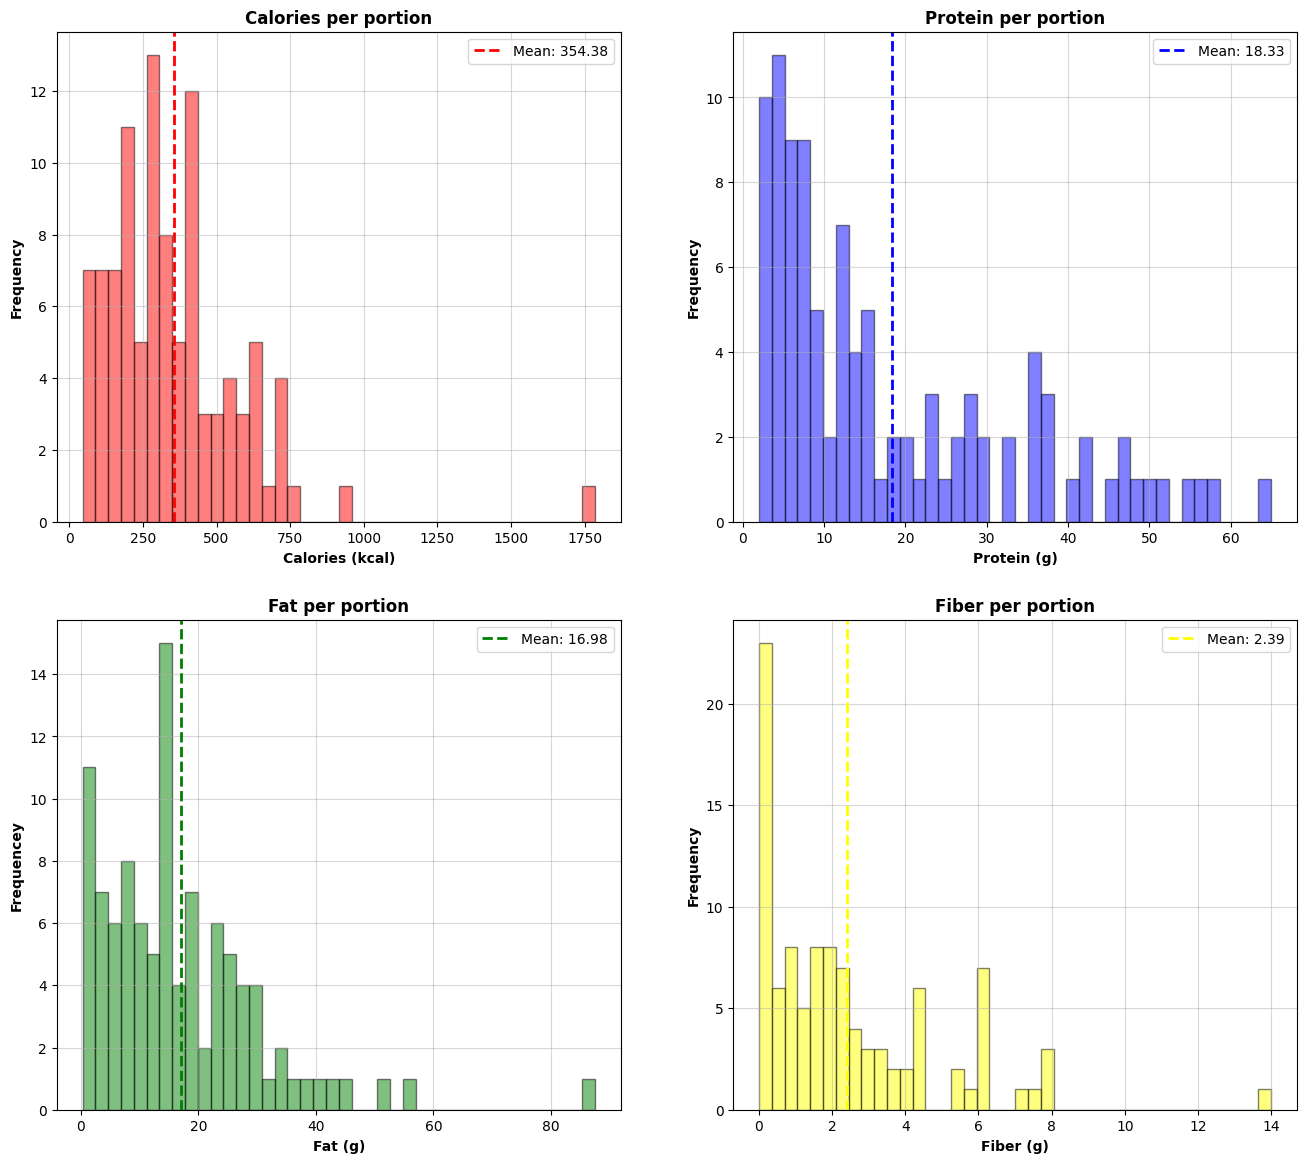

In [ ]:
fig, ax=plt.subplots(2, 2, figsize=(16, 14))

ax[0, 0].hist(complete_nutrition['calories_perportion'], bins=40, edgecolor='black', color='red', alpha=0.5)
ax[0, 0].axvline(complete_nutrition['calories_perportion'].mean(), color='red', linestyle='--', linewidth='2', label=(f'Mean: {complete_nutrition['calories_perportion'].mean():.2f}'))
ax[0, 0].set_xlabel(f'Calories (kcal)', fontsize=10, fontweight='bold')
ax[0, 0].set_ylabel(f'Frequency', fontsize=10, fontweight='bold')
ax[0, 0].set_title(f'Calories per portion', fontsize=12, fontweight='bold')
ax[0, 0].legend()
ax[0, 0].grid(alpha=0.5)

ax[0, 1].hist(complete_nutrition['protein_perportion'], bins=40, edgecolor='black', color='blue', alpha=0.5)
ax[0, 1].axvline(complete_nutrition['protein_perportion'].mean(), color='blue', linestyle='--', linewidth=2, label=(f'Mean: {complete_nutrition['protein_perportion'].mean():.2f}'))
ax[0, 1].set_xlabel(f'Protein (g)', fontsize=10, fontweight='bold')
ax[0, 1].set_ylabel(f'Frequency', fontsize=10, fontweight='bold')
ax[0, 1].set_title(f'Protein per portion', fontsize=12, fontweight='bold')
ax[0, 1].legend()
ax[0, 1].grid(alpha=0.5)

ax[1, 0].hist(complete_nutrition['fat_perportion'], bins=40, edgecolor='black', color='green', alpha=0.5)
ax[1, 0].axvline(complete_nutrition['fat_perportion'].mean(), color='green', linestyle='--', linewidth=2, label=(f'Mean: {complete_nutrition['fat_perportion'].mean():.2f}'))
ax[1, 0].set_xlabel(f'Fat (g)', fontsize=10, fontweight='bold')
ax[1, 0].set_ylabel(f'Frequencey', fontsize=10, fontweight='bold')
ax[1, 0].set_title(f'Fat per portion', fontsize=12, fontweight='bold')
ax[1, 0].legend()
ax[1, 0].grid(alpha=0.5)

ax[1, 1].hist(complete_nutrition['fiber_perportion'], bins=40, edgecolor='black', color='yellow', alpha=0.5)
ax[1, 1].axvline(complete_nutrition['fiber_perportion'].mean(), color='yellow', linestyle='--', linewidth=2, label=(f'Mean: {complete_nutrition['fiber_perportion'].mean():.2f}'))
ax[1, 1].set_xlabel(f'Fiber (g)', fontsize=10, fontweight='bold')
ax[1, 1].set_ylabel(f'Frequency', fontsize=10, fontweight='bold')
ax[1, 1].set_title(f'Fiber per portion', fontsize=12, fontweight='bold')
ax[1, 1].legend()
ax[1, 1].grid(alpha=0.5)

plt.suptitle(f'Nutrition distribution', fontsize=14, fontweight='bold')

plt.show()

In [ ]:
ax[0].hist(portions_df['default_portion_g'], bins=40, edgecolor='black', color='blue', alpha=0.5)
ax[0].axvline(portions_df['default_portion_g'].mean(), color='red', linestyle='--', linewidth=2, label=(f'Mean: {portions_df['default_portion_g'].mean():.2f}'))
ax[0].set_xlabel('Portion size (g)', fontsize=10, fontweight='bold')
ax[0].set_ylabel('Frequency', fontsize=10, fontweight='bold')
ax[0].set_title('Distribution of food portion sizes', fontsize=14, fontweight='bold')
ax[0].legend()
ax[0].grid(alpha=0.5)